## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import zscore

from sherlock_helpers.constants import DATA_DIR, FIG_DIR
from sherlock_helpers.functions import (
    corr_mean,
    get_recall_text, 
    get_video_text, 
    show_source
)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Helper functions and variables used across multiple notebooks can be found in `/mnt/code/sherlock_helpers/sherlock_helpers`, or on GitHub, [here](https://github.com/ContextLab/sherlock-topic-model-paper/tree/master/code/sherlock_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from sherlock_helpers.functions import show_source<br />    show_source(foo)</pre>

## Inspect some functions

In [2]:
show_source(corr_mean)

In [3]:
show_source(get_video_text)

In [4]:
show_source(get_recall_text)

## Set plotting params

In [5]:
sns.set_context('paper')
sns.set_style('ticks')
sns.set_palette('hls', 17)
mpl.rcParams['pdf.fonttype'] = 42

## Load data

In [6]:
video_events = np.load(DATA_DIR.joinpath('video_events.npy'), allow_pickle=True)
recall_events = np.load(DATA_DIR.joinpath('recall_events.npy'), allow_pickle=True)

video_event_times = np.load(DATA_DIR.joinpath('video_event_times.npy'), allow_pickle=True)
recall_event_times = np.load(DATA_DIR.joinpath('recall_event_times.npy'), allow_pickle=True)

matches = np.load(DATA_DIR.joinpath('labels.npy'), allow_pickle=True)

## Compute distinctiveness

In [7]:
dist_df = pd.DataFrame(index=range(len(recall_events)), 
                       columns=range(video_events.shape[0]))

for sub, rec_events in enumerate(recall_events):
    corrmat = 1 - cdist(video_events, rec_events, 'correlation')
    z_corrs = zscore(corrmat, axis=0)
    matched_events = z_corrs.argmax(axis=0)
    dist_scores = z_corrs.max(axis=0)
    for ix, video_event in enumerate(matched_events):
        if dist_scores[ix] < dist_df.loc[sub, video_event]:
            continue
            
        dist_df.loc[sub, video_event] = dist_scores[ix]
    
dist_df['Participant'] = [f'P{i + 1}' for i in range(len(recall_events))]
dist_df = dist_df.melt(id_vars=['Participant'], 
                       var_name='Episode event', 
                       value_name='Distinctiveness')
dist_df['Distinctiveness'] = dist_df['Distinctiveness'].astype(np.float64)
dist_df['Episode event'] += 1

## Plot by video event

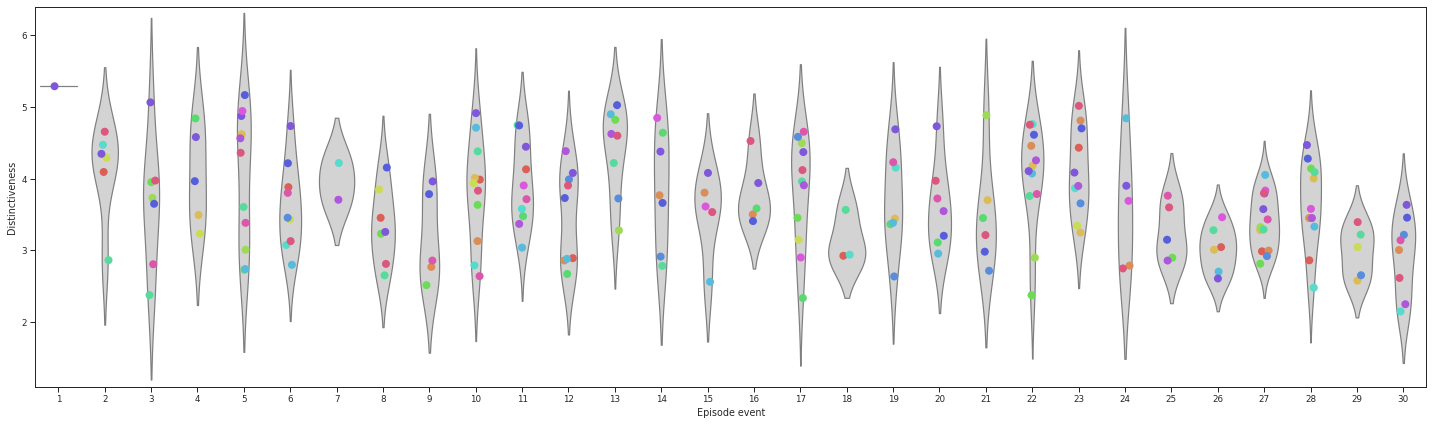

In [8]:
g = sns.catplot(x='Episode event', 
                y='Distinctiveness', 
                data=dist_df, 
                kind='violin',
                color='lightgrey', 
                inner=None)

g.fig.set_size_inches(20, 6)
sns.stripplot(x='Episode event', 
              y='Distinctiveness', 
              hue='Participant', 
              data=dist_df, 
              size=8, 
              ax=g.ax)

hs, ls = g.ax.get_legend_handles_labels()
g.ax.legend_.remove()

for sp in g.ax.spines.values():
    sp.set_visible(True)
    
plt.ylim(1.1, 6.4)

plt.tight_layout()
# plt.savefig(FIG_DIR.joinpath('tmp', 'distinctiveness_detail_vid.pdf'))
plt.show()

## Recover text from the video and most and least distinctive recall for a sample event

In [9]:
sample_event = 22
event_dist_scores = dist_df.loc[dist_df['Episode event'] == sample_event]
high_rec = event_dist_scores.loc[event_dist_scores['Distinctiveness'].idxmax(), 'Participant']
low_rec = event_dist_scores.loc[event_dist_scores['Distinctiveness'].idxmin(), 'Participant']

print(f'video event: {sample_event}\n', 
      f'most distinctive: {high_rec}\n', 
      f'least distinctive: {low_rec}')

video event: 22
 most distinctive: P9
 least distinctive: P6


In [10]:
sample_event_bounds = video_event_times[sample_event - 1]
prev_event_bounds = video_event_times[sample_event - 2]
prev2_event_bounds = video_event_times[sample_event - 3]
prev3_event_bounds = video_event_times[sample_event - 4]
prev4_event_bounds = video_event_times[sample_event - 5]
prev5_event_bounds = video_event_times[sample_event - 6]
prev6_event_bounds = video_event_times[sample_event - 14]

next_event_bounds =  video_event_times[sample_event]
next2_event_bounds =  video_event_times[sample_event + 1]
next3_event_bounds = video_event_times[sample_event + 2]

video_event_text = get_video_text(*sample_event_bounds)
prev_event_text = get_video_text(*prev_event_bounds)
prev2_event_text = get_video_text(*prev2_event_bounds)
prev3_event_text = get_video_text(*prev3_event_bounds)
prev4_event_text = get_video_text(*prev4_event_bounds)
prev5_event_text = get_video_text(*prev5_event_bounds)
prev6_event_text = get_video_text(*prev6_event_bounds)

next_event_text = get_video_text(*next_event_bounds)
next2_event_text = get_video_text(*next2_event_bounds)
next3_event_text = get_video_text(*next3_event_bounds)

In [11]:
high_sub, low_sub = int(high_rec[1:]) - 1, int(low_rec[1:]) - 1

high_rec_bounds = np.array(recall_event_times[high_sub])[matches[high_sub] == sample_event - 1][0]
low_rec_bounds = np.array(recall_event_times[low_sub])[matches[low_sub] == sample_event - 1][0]

high_rec_text = get_recall_text(*high_rec_bounds, subid=high_sub + 1)
low_rec_text = get_recall_text(*low_rec_bounds, subid=low_sub + 1)

In [12]:
print(prev6_event_text)

John says: "We've only just met and we're gonna go and look at a flat?" Sherlock looks in Mike's direction then back at John and says: "Problem?" John smiles incredulously and looks at Mike.  Mike stares at Sherlock with a smug smile.  John turns back to Sherlock and says: "We don't know a thing about each other; I don't know where we're meeting; I don't even know your name." Sherlock pauses and looks closely at John Sherlock looks intently at John and says very quickly and precisely: " I know you're an Army doctor and you've been invalided home from Afghanistan. I know you've got a brother who's worried about you, but you won't go to him for help because you don't approve of him - possibly because he's an alcoholic..." John looks dumbfounded and stares at Sherlock as Sherlock continues "….more likely because he recently walked out on his wife." Shot of Sherlock as he continues: "…And I know that your therapist thinks your limp is psychosomatic…" Sherlock glances down at John's legs.  

In [13]:
print(prev5_event_text)

He squats down beside the body and runs his gloved hand along the back of her coat, then lifts his hand again to look at his fingers: wet Sherlock reaches into the corpse's coat pockets.  John watches keenly Sherlock finds a white folding umbrella in one of them. Running his fingers along the folds of the material, he then inspects his glove again: dry Sherlock puts the umbrella back in her pocket.  Sherlock moves up to the collar of her coat and runs his fingers underneath it  Sherlocks looks again at his fingers: wet Lestrade stares keenly at Sherlock Reaching into his pocket, Sherlock takes out a magnifier and clicks it open Sherlock closely inspects the delivate gold bracelet on her left wrist: clean Sherlock leans a little closer to see her gold earring attached to her left ear: clean Sherlock also takes a look at the gold chain around her neck: clean Sherlock puts his magnifying glass closer toward the victim's left hand to look at her rings.  A view of the wedding ring and engag

In [14]:
print(prev4_event_text)

John looks up from the body to Sherlock and says: "Hm?" Then he turns his head towards Lestrade, silently seeking his permission.  Lestrade, a little tetchily, says: "Oh, do as he says. Help yourself" He turns and opens the door, going outside.  Lestrade says in the background: "Anderson, keep everyone out for a couple of minutes" as John and Sherlock approach the corpse on each of her sides and squat down. John painfully lowers himself to one knee on the other side, learning heavily on his cane to support himself.  Sherlock looks toward John and asks: "Well?" John asks softly: "What am I doing here?" Sherlock whispers: "Helping me make a point." John softly replies: "I'm supposed to be helping you pay the rent." Sherlock replies softly: "Yeah well, this is more fun." John asks: "Fun? There's a woman lying dead." Sherlock admits: "Perfectly sound analysis, but I was hoping you'd go deeper." Lestrade comes back into the room and stands just inside the doorway John drags his other leg do

In [15]:
print(prev3_event_text)

John looks at Sherlock in shock as Sherlock gets up and continues: "…so what or rather whom does she remove her rings for?" Sherlock: "Clearly not one lover; she'd never sustain the fiction of being single over that amount of time, so more likely a string of them. Simple." John admiringly says to Sherlock: "That's brilliant." Sherlock looks round at him and John immediately says: "Sorry."  Lestrade asks: "Cardiff?" Sherlock says: "It's obvious, isn't it?" John: "It's not obvious to me." and stares at Sherlock.  Sherlock pauses as he looks at the other two men and says seriously: "Dear God, what is it like in your funny little brains? It must be so boring." Sherlock turns back to the body and explains in a lively manner: "Her coat: it's slightly damp. She's been in heavy rain in the last few hours. No rain anywhere in London in that time." Sherlock continues, looking at Lestrade: "Under her coat collar is damp, too. She's turned it up against the wind. She's got an umbrella in her left-

In [16]:
print(prev2_event_text)

Sherlock, slowing down, but still making his way down the stairs, says: "But they take the poison themselves; they chew, swallow the pills themselves. There are clear signs. Even you lot couldn't miss them" Lestrade: "Right, yeah, thanks!" He callls out loudly down the stairs: "AND…?" John stays silent beside Lestrade. The two stay upstairs.  Sherlock reaches a floor where Anderson and two other people dressed in coveralls as well as another policeman are patiently waiting. Sherlock calls up the stairs to answer Lestrade: "It's murder, all of them. I don't know how, but they're not suicides, they're killings..." View of Lestrade and John looking down at the stair railings. Sherlock continues: "…serial killings." Sherlock abruptly holds his hands in front of his face in delight. Sherlock says joyfully: "We've got ourselves a serial killer. I love those. There's always something to look forward to." Sherlock continues down the next flight of stairs quickly. He passes by another policeman

In [17]:
print(prev_event_text)

John walks toward the police tape, still looking around. Donovan is at the police tape speaking with a police man.  Donovan, standing at the tape alongside a police man, sees him and says: "He's gone." John asks Donovan: "Sherlock Holmes?" Donovan: "Yeah, he just took off. He does that." John asks Donovan: "Is he coming back?" Donovan: "Didn't look like it." John: "Right." He looks around the area again thoughtfully, unsure of what to do. John says quietly: "Right….yes." Donovan has gone back to talking with the police man near the tape.  John turns to Donovan again and asks: "Sorry, where am I?" Donovan turns around and answers: "Brixton."  John asks Donovan: "Right. Er, d'you know where I could get a cab? It's just, er… well…" H e looks down awkwardly at his walking stick and says: "…my leg." Donovan: "Er…" She stepss over to the tape and lifts it for him and says: "…try the main road." John says: "Thanks" and ducks under the tape.  Donovan says: "But you're not his friend." John sto

In [18]:
print(video_event_text)

Donovan turns around toward John and calls out to John: "Stay away from Sherlock Holmes" John watches her go, then looks around for a moment.  John turns and eyes the distance he has to go to get to the main road.  John begins to limp down the road. He is looking up toward his left. The sound of a telephone ringing is heard and John stops walking.  John turns to where the sound is coming from. It is from a public telephone in a red booth. He looks at it for a few seconds.  John looks down at his watch, shakes his head and continues down the road.  A view of the telephone booth. It stops ringing as John starts walking away.  Not long afterwards, John is walking down the main road. He tries to hail a passing taxi. John yells out: "Taxi! Taxi…" The taxi passes him by In Chicken Cottage, the fast food restaurant outside which John is stand, the payphone on the wall begins to ring. John turns and looks as one of the serving staff walks over to it but as he reaches for the phone, it stops.  

In [19]:
print(next_event_text)

A shot of the CCTV camera high up on the wall of a nearby building John replies: "Yeah, I see it."  The Man says: "Watch." The camera, which was pointing directly at the phone box, now swivels away. John is no longer visible through the camera.  The screen is split into four. Supposedly four cameras (Brixton 053, Brixton 002, Brixton 051, Brixton 047) that show what is going on on the street. Brixton 051, the camera that has just swivelled, now shows a close up of the road. Nothing else is visible. Brixton 053 and Brixton 047 are still showing John in the phone booth at different angles.  The man says: "There's another camera on the building opposite to you." John looks around to find it.  A shot of the other CCTV camera. The man's voice continues: "Do you see it?" John does not answer, but he is looking in the camera's direction.  The camera immediately swivels away.  The man: "And finally, at the top of the buliding on your right." John turns his head to find the camera.  Camera's po

In [20]:
print(next2_event_text)

In front of the man is a straight-backed armless chair facing him. He gestures to it with the point of his umbrella and says: "Have a seat, John." His face is visible.  As John continues to limp toward the man; his voice is calm as he says: "You know, I've got a phone." He looks around the warehouse. John continues: "I mean, very clever and all that but er….you could just phone me. On my phone." He walks straight past the chair and stops a few paces in front of the man.  The Man: "When one is avoiding the attention of Sherlock Holmes, one learns to be discreet, hence this place." The  The Man gestures to the warehouse. He continues: "The leg must be hurting you." The Man's voice, which has had a pleasant smile in it so far, now becomes a little more stern. He says: "Sit Down." John looks straight at the Man and says: "I don't want to sit down."  The Man looks at him curiously and says: "You don't seem very afraid." John says: "You don't seem very frightening." The Man chuckles and says

In [21]:
print(next3_event_text)

The Man continues: "…Baker Street, I'd be happy to pay you a meaningful…" The Man continues: "…sum of money on a regular basis to…" He closes his notebook and puts it away again, then continues: "…ease your way." John asks: "Why?"   The Man replies in a matter-of-fact way: "Because you're not a wealthy man." John: "In exchange for what?" The Man pauses for a moment and says: "Information. Nothing indiscreet. Nothing you'd feel…uncomfortable with." The Man continues: "Just tell me what he's up to."  John asks: "Why?" The Man replies: "I worry about him…constantly." Johns says insincerely: "That's nice of you." The Man: "But I would prefer for various reasons that my concern go unmentioned. We have what you might call a…" The man looks at the tip of his umbrella for a moment, then says: "... difficult relationship."  John's phone trills another text alert.  John immediately takes his phone out  John looks at the message, which reads: If inconvenient, come anyway. SH John closes the messa

In [22]:
print(high_rec_text)

She's also married unhappily, and must be seeing some guys on the side. Watson is most stumped by the fact that Sherlock could figure out that she was from Cardiff. And then Watson does his little bit, says that she died of asphyxiation, at which point it becomes clear that the spate of killings are not suicides but in fact murders. Perhaps this is also added to the fact that because she was staying overnight and there wasn't a suitcase nearby, Sherlock could deduce that the serial killer had messed up and tripped up and by not leaving the suitcase, showing that they're not suicides, they're murders, that there's a third party acting. So Sherlock runs off excitedly, forgets about Watson. Watson walks outside, confronts the police officer, the female police officer from the start of the scene, and she warns him about these tendencies and she sort of deduces that, she says that Sherlock must be, you know, sort of semi-psychotic, and that he could be the next murderer, sort of thing. So W

In [23]:
print(low_rec_text)

But the bag disappears, he figures it is pink just like her suit, her sportcoat.   He asks Watson to examine the body and Watson says it looks like strangling or asphyxiation, she doesn't seem drunk.   Oh and before the show we see the same pills in a container on the floor and we've just seen a woman's hand reaching down for them but we did not see the woman.   So we had some advanced warning of this additional death.  Sherlock ends up kind of running out of the room he has a eureka moment about the first mistake that the--first of all he says he thinks they are murders not suicides, that they have a serial killer on their hands, and he has a eureka moment, he gets really caught up and excited, and he runs off to find the suitcase leaving Watson alone. Watson comes out of the building and asks the female police detective earlier where he can find a cab.  And she warns him about getting too close to Sherlock because Sherlock doesn't have any friends and is kind of psychopathic in his a